# Setup

In [ ]:
# Tweepy
import tweepy

# DataFrame
import pandas as pd

# Matplot
from matplotlib import pyplot as plt

# Utility
import numpy as np
from numpy import array       
from numpy import asarray
from numpy import zeros
import math
import re
import string
import pickle
import random
import csv

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

# Keras
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, GRU, Bidirectional, Dropout
from keras.layers.embeddings import Embedding

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Pre-processing training data

In [ ]:
col = ['target', 'text']
train_df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', names=col, usecols=[0,5])

def clean_text(sentence):
    stop_words = stopwords.words('english')
    tokenizer = TweetTokenizer()
    tweet_tokens = tokenizer.tokenize(str(sentence))

    final_token = []
    for token in tweet_tokens:
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                        '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub('RT','', token)
        token = re.sub('(@[A-Za-z0-9_]+)','', token)
        token = re.sub('(#[A-Za-z0-9_]+)','', token)
 
        token = re.sub('“','', token)
        token = re.sub('”','', token)
        token = re.sub('’','', token)
        token = re.sub('—','', token)
 
        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            final_token.append(token.lower())
            
    return ' '.join(final_token)

decode = {0: "NEGATIVE", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode[int(label)]

def add_end_token(sentence):
  sent = sentence + ' <end>'
  return sent

# cleaning
train_df.text = train_df.text.apply(lambda x: clean_text(x))
train_df.text = train_df.text.apply(lambda x: add_end_token(x))
train_df.target = train_df.target.apply(lambda x: decode_sentiment(x))

# dataframe to list
train_list = train_df['text'].values.tolist()
target_list = train_df['target'].values.tolist()

# tokenize
tokenizer = TweetTokenizer()
train_list = [tokenizer.tokenize(sent) for sent in train_list]

# Word to index - Index to word

In [ ]:
words = set()
for sent in train_list:
  for word in sent:
    words.add(word)
 
targets = set()
for t in target_list:
  targets.add(t)

In [ ]:
print('Vocab:', len(words))
print('Target:', len(targets))

Vocab: 332263
Target: 2


In [ ]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
word2idx["UNK"] = 0
idx2word = {i: w for w, i in word2idx.items()}

target2idx = {t: i for i, t in enumerate(targets)}
idx2target = {i: w for w, i in target2idx.items()}  

In [ ]:
print('sample (train_list)', train_list[0])
print('sample (word to index)', {w : word2idx[w] for w in train_list[0]})

sample (train_list) ['awww', "that's", 'bummer', 'shoulda', 'got', 'david', 'carr', 'third', 'day', ';d', '<end>']
sample (word to index) {'awww': 60866, "that's": 123392, 'bummer': 314991, 'shoulda': 20369, 'got': 260506, 'david': 298616, 'carr': 108376, 'third': 136789, 'day': 92212, ';d': 217622, '<end>': 279645}


In [ ]:
# Save
with open('word2idx.pickle', 'wb') as handle:
    pickle.dump(word2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('idx2word.pickle', 'wb') as handle:
    pickle.dump(idx2word, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('target2idx.pickle', 'wb') as handle:
    pickle.dump(target2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('idx2target.pickle', 'wb') as handle:
    pickle.dump(idx2target, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Training

In [ ]:
# Load word2idx tag2idx ...
with open('word2idx.pickle', 'rb') as handle:
    word2idx = pickle.load(handle)
with open('idx2word.pickle', 'rb') as handle:
    idx2word = pickle.load(handle)
with open('target2idx.pickle', 'rb') as handle:
    target2idx = pickle.load(handle)
with open('idx2target.pickle', 'rb') as handle:
    idx2target = pickle.load(handle)

words = set()
for sent in train_list:
  for word in sent:
    words.add(word)
 
targets = set()
for t in target_list:
  targets.add(t)

max_len_sentence = 100

X = [[word2idx[word] for word in sent] for sent in train_list]
X = pad_sequences(maxlen=max_len_sentence, sequences=X, value=word2idx["UNK"], padding='post', truncating='post')
y = [target2idx[t] for t in target_list]
y = array(y).reshape(-1,1)

# 70% training data 30% testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5555)

## Covid Word Embedding

https://www.kaggle.com/davidmezzetti/cord19-fasttext-vectors

In [ ]:
embeddings_dictionary = dict()

fast_file = open('cord19-300d.txt', encoding="utf8")
for line in fast_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
fast_file.close()
 
embedding_matrix = zeros((len(words) + 1, 300))
for word, index in word2idx.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
def get_bidirectional_gru():
  model = Sequential()

  model.add(Embedding(len(words)+1, 300, weights=[embedding_matrix], input_length=max_len_sentence, trainable=False))
  model.add(Dropout(0.5))
  model.add(Bidirectional(GRU(128)))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
 
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
  model.summary()
 
  return model

model = get_bidirectional_gru()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          99679200  
_________________________________________________________________
dropout (Dropout)            (None, 100, 300)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               330240    
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 100,025,953
Trainable params: 346,753
Non-trainable params: 99,679,200
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs=10, validation_split=0.1, verbose=1, batch_size=1024)

Epoch 1/10
985/985 [==============================] - 115s 117ms/step - loss: 0.5553 - acc: 0.7090 - val_loss: 0.5014 - val_acc: 0.7528
Epoch 2/10
985/985 [==============================] - 118s 119ms/step - loss: 0.5165 - acc: 0.7404 - val_loss: 0.4893 - val_acc: 0.7620
Epoch 3/10
985/985 [==============================] - 119s 120ms/step - loss: 0.5067 - acc: 0.7478 - val_loss: 0.4809 - val_acc: 0.7674
Epoch 4/10
985/985 [==============================] - 120s 122ms/step - loss: 0.4996 - acc: 0.7531 - val_loss: 0.4776 - val_acc: 0.7696
Epoch 5/10
985/985 [==============================] - 120s 122ms/step - loss: 0.4952 - acc: 0.7559 - val_loss: 0.4817 - val_acc: 0.7655
Epoch 6/10
985/985 [==============================] - 120s 122ms/step - loss: 0.4911 - acc: 0.7585 - val_loss: 0.4713 - val_acc: 0.7737
Epoch 7/10
985/985 [==============================] - 120s 121ms/step - loss: 0.4886 - acc: 0.7602 - val_loss: 0.4729 - val_acc: 0.7711
Epoch 8/10
985/985 [============================

### Model graph

Loss graph

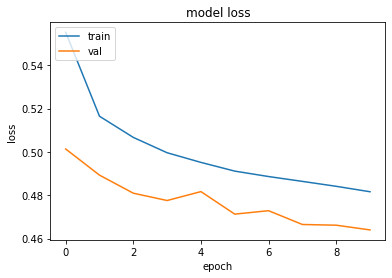

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Model accuracy graph

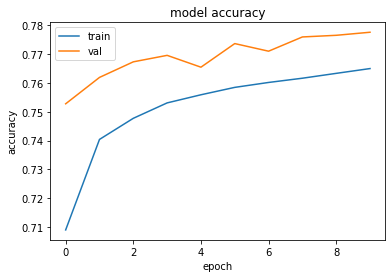

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def decode_sentiment(score):
  return 1 if score > 0.5 else 0

y_pred = []
scores = model.predict(X_test)
y_pred = [decode_sentiment(score) for score in scores]

In [ ]:
covid_emb_report = classification_report(y_test, y_pred, target_names=['POSITIVE','NEGATIVE'])
covid_emb_acc = accuracy_score(y_test, y_pred)
print(covid_emb_report)
covid_emb_report = classification_report(y_test, y_pred, target_names=['POSITIVE','NEGATIVE'], output_dict=True)
print('Accuracy = %.3f' %covid_emb_acc)

              precision    recall  f1-score   support

    POSITIVE       0.77      0.78      0.78    240226
    NEGATIVE       0.78      0.77      0.77    239774

    accuracy                           0.78    480000
   macro avg       0.78      0.78      0.78    480000
weighted avg       0.78      0.78      0.78    480000

Accuracy = 0.776


## English Word Embedding
https://fasttext.cc/docs/en/crawl-vectors.html

In [ ]:
embeddings_dictionary = dict()

fast_file = open('cc.en.300.vec', encoding="utf8")
for line in fast_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
fast_file.close()
 
embedding_matrix = zeros((len(words) + 1, 300))
for word, index in word2idx.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
def get_bidirectional_gru():
  model = Sequential()

  model.add(Embedding(len(words)+1, 300, weights=[embedding_matrix], input_length=max_len_sentence, trainable=False))
  model.add(Dropout(0.5))
  model.add(Bidirectional(GRU(128)))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
 
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
  model.summary()
 
  return model

model = get_bidirectional_gru()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          99679200  
_________________________________________________________________
dropout (Dropout)            (None, 100, 300)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               330240    
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 100,025,953
Trainable params: 346,753
Non-trainable params: 99,679,200
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs=10, validation_split=0.1, verbose=1, batch_size=1024)

Epoch 1/10
985/985 [==============================] - 125s 126ms/step - loss: 0.5406 - acc: 0.7225 - val_loss: 0.4896 - val_acc: 0.7653
Epoch 2/10
985/985 [==============================] - 126s 128ms/step - loss: 0.5026 - acc: 0.7511 - val_loss: 0.4719 - val_acc: 0.7735
Epoch 3/10
985/985 [==============================] - 126s 128ms/step - loss: 0.4904 - acc: 0.7593 - val_loss: 0.4639 - val_acc: 0.7775
Epoch 4/10
985/985 [==============================] - 126s 128ms/step - loss: 0.4826 - acc: 0.7646 - val_loss: 0.4593 - val_acc: 0.7813
Epoch 5/10
985/985 [==============================] - 126s 128ms/step - loss: 0.4765 - acc: 0.7683 - val_loss: 0.4529 - val_acc: 0.7853
Epoch 6/10
985/985 [==============================] - 126s 128ms/step - loss: 0.4710 - acc: 0.7719 - val_loss: 0.4526 - val_acc: 0.7841
Epoch 7/10
985/985 [==============================] - 126s 128ms/step - loss: 0.4671 - acc: 0.7749 - val_loss: 0.4469 - val_acc: 0.7900
Epoch 8/10
985/985 [============================

In [ ]:
model.save('bi_gru_model_10_epoch_general_word_embedding.h5')

### Model graph

Loss graph

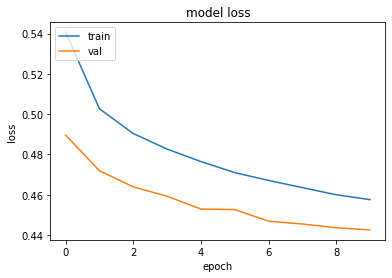

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Model accuracy graph

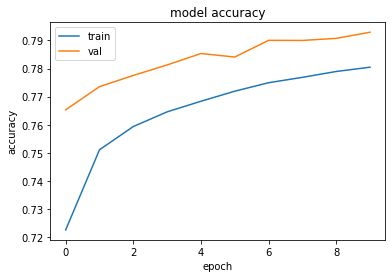

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model = load_model('bi_gru_model_10_epoch_general_word_embedding.h5')

In [ ]:
def decode_sentiment(score):
  return 1 if score > 0.5 else 0

y_pred = []
scores = model.predict(X_test)
y_pred = [decode_sentiment(score) for score in scores]

In [ ]:
english_emb_report = classification_report(y_test, y_pred, target_names=['POSITIVE','NEGATIVE'])
english_emb_acc = accuracy_score(y_test, y_pred)
print(english_emb_report)
english_emb_report = classification_report(y_test, y_pred, target_names=['POSITIVE','NEGATIVE'], output_dict=True)
print('Accuracy = %.3f' %english_emb_acc)

              precision    recall  f1-score   support

    POSITIVE       0.80      0.77      0.79    240226
    NEGATIVE       0.78      0.81      0.79    239774

    accuracy                           0.79    480000
   macro avg       0.79      0.79      0.79    480000
weighted avg       0.79      0.79      0.79    480000

Accuracy = 0.791


## Comparison graph

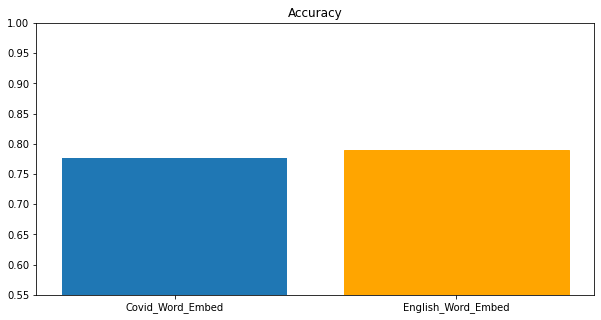

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Accuracy')
axes = plt.gca()
axes.set_ylim([0.55,1.0])
bar = plt.bar(['Covid_Word_Embed', 'English_Word_Embed'], [covid_emb_acc, english_emb_acc])
bar[1].set_color('orange')
plt.show()

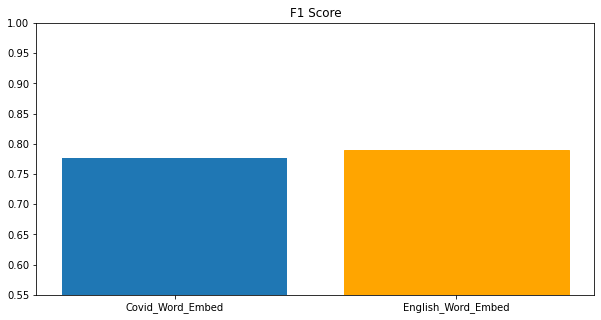

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('F1 Score')
axes = plt.gca()
axes.set_ylim([0.55,1.0])
bar = plt.bar(['Covid_Word_Embed', 'English_Word_Embed'], [covid_emb_report['macro avg']['f1-score'], english_emb_report['macro avg']['f1-score']])
bar[1].set_color('orange')
plt.show()